In [ ]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt

# Numpy

In [ ]:
X  = np.arange(-5, 6, 1)
X_test  = np.random.choice(X, 1)
X_train = X[X != X_test]

In [ ]:
def rbf_kernel(x1, x2, lengthscale=1.0, sigma=1.0):
    return sigma**2 * np.exp(-0.5 * (x1 - x2)**2 / lengthscale**2)

def rbf_kernel_matrix(X1, X2, lengthscale=1.0, sigma=1.0):
    K = np.zeros((len(X1), len(X2)))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            K[i, j] = rbf_kernel(x1, x2, lengthscale, sigma)
    return K

In [ ]:
X  = np.linspace(-5, 5, 100)
f = np.random.multivariate_normal(
    mean=np.zeros(len(X)),
    cov=rbf_kernel_matrix(X, X, lengthscale=1.0, sigma=1.0),
)


In [ ]:
X = np.linspace(-5, 5, 100)
f = np.sin(X)  # or any "true" function you want to compare to

X_train = np.array([-4, -2, 0, 2, 4])
y_train = np.sin(X_train)  # Some fake data for now
X_test = np.linspace(-5, 5, 100)

K_train  = rbf_kernel_matrix(X_train, X_train, lengthscale=1.0, sigma=1.0)
K_s      = rbf_kernel_matrix(X_test, X_train, lengthscale=1.0, sigma=1.0)
K_inv    = np.linalg.inv(K_train + 1e-8 * np.eye(len(X_train)))

mu_post = K_s @ K_inv @ y_train

K_ss = rbf_kernel_matrix(X_test, X_test, lengthscale=1.0, sigma=1.0)
cov_post = K_ss - K_s @ K_inv @ K_s.T



plt.figure(figsize=(10, 5)) 
plt.plot(X, f, 'r', label='True function')
plt.scatter(X_train, y_train, c='b', label='Training points')
plt.scatter(X_test, mu_post, c='g', label='Posterior mean', alpha=0.5)
plt.fill_between(X_test, mu_post - 1.96 * np.sqrt(np.diag(cov_post)),
                 mu_post + 1.96 * np.sqrt(np.diag(cov_post)), color='gray', alpha=0.5)
plt.title('Gaussian Process Regression')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend()
plt.show()

# GPytorch

## Exact

In [ ]:


# Toy data
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * torch.pi)) + torch.randn(train_x.size()) * 0.2

# Define GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Train
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Evaluate
model.eval()
likelihood.eval()
test_x = torch.linspace(0, 1, 200)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = model(test_x)

# Plot
mean = preds.mean.numpy()
lower, upper = preds.confidence_region()
plt.figure(figsize=(10, 6))
plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
plt.plot(test_x.numpy(), mean, 'b')
plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
plt.title("GPyTorch GP Regression")
plt.show()


# VariationalGP

In [ ]:
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution

class VariationalGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_dist = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_dist, learn_inducing_locations=True)
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = train_x[::10]  # Choose 10 inducing points
model = VariationalGPModel(inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()


In [ ]:
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Use variational ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

for i in range(300):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()


In [ ]:
model.eval()
likelihood.eval()
test_x = torch.linspace(0, 1, 200)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(test_x))

mean = preds.mean
lower, upper = preds.confidence_region()

plt.figure(figsize=(10, 6))
plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
plt.plot(test_x.numpy(), mean.numpy(), 'b')
plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
plt.title("Variational GP Regression (GPyTorch)")
plt.show()


## SparseGPRegression

In [ ]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy

class SparseGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_dist = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_dist, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Create model and likelihood
inducing_points = torch.linspace(0, 1, 10)  # Pick 10 inducing points
model = SparseGPModel(inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()



In [ ]:
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Use variational ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

for i in range(300):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

In [ ]:
model.eval()
likelihood.eval()
test_x = torch.linspace(0, 1, 200)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(test_x))

mean = preds.mean
lower, upper = preds.confidence_region()

plt.figure(figsize=(10, 6))
plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
plt.plot(test_x.numpy(), mean.numpy(), 'b')
plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
plt.title("Variational GP Regression (GPyTorch)")
plt.show()

## GPsparse with mini batch

In [ ]:
import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt

# 🔧 Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Create synthetic dataset
train_x = torch.linspace(0, 1, 100).to(device)
train_y = torch.sin(train_x * (2 * torch.pi)) + torch.randn(train_x.size()) * 0.2
train_y = train_y.to(device)

# ✅ Wrap dataset for minibatching
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.models import ApproximateGP

class SparseGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(0), batch_shape=torch.Size([])
        )
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# ✅ Choose inducing points and move to device
inducing_points = train_x[::10].clone().detach()  # 10 inducing points
model = SparseGPModel(inducing_points.to(device)).to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)


In [ ]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_dataset))

num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}/{num_epochs} - Loss: {total_loss:.3f}")


In [ ]:
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 1, 200).to(device)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(test_x))

mean = preds.mean.cpu().numpy()
lower, upper = preds.confidence_region()
lower = lower.cpu().numpy()
upper = upper.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(train_x.cpu(), train_y.cpu(), 'k*')
plt.plot(test_x.cpu(), mean, 'b')
plt.fill_between(test_x.cpu().numpy(), lower, upper, alpha=0.3)
plt.title("Sparse Variational GP (Minibatch + CUDA)")
plt.show()


## Multiple time series:

In [ ]:
import torch
import gpytorch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt


In [ ]:
# Let’s create a toy example with 5 time series, each being a noisy sine wave with slight variation.

class MultiTimeSeriesDataset(Dataset):
    def __init__(self, num_series=5, num_points=450):
        self.num_series = num_series
        self.num_points = num_points
        self.x = torch.linspace(0, 1, num_points).unsqueeze(-1)  # [T, 1]

        self.y = []
        for i in range(num_series):
            # Slightly different frequency and noise
            freq = 1.0 + 0.2 * torch.randn(1)
            phase = 0.5 * torch.randn(1)
            y_series = torch.sin(freq * 2 * torch.pi * self.x + phase) + 0.2 * torch.randn_like(self.x)
            self.y.append(y_series)

        self.y = torch.stack(self.y)  # [N, T, 1]

    def __len__(self):
        return self.num_series

    def __getitem__(self, idx):
        return self.x.squeeze(), self.y[idx].squeeze()

# Load dataset
dataset = MultiTimeSeriesDataset(num_series=5)
loader = DataLoader(dataset, batch_size=5, shuffle=False)


In [ ]:
class BatchedGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_inducing=64, num_tasks=5):
        self.num_tasks = num_tasks

        # Shared inducing points across all series
        inducing_points = torch.linspace(0, 1, num_inducing).unsqueeze(-1)  # [M, 1]
        inducing_points = inducing_points.repeat(num_tasks, 1, 1)  # [N, M, 1]

        # Create variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=torch.Size([num_tasks])
        )

        # Create the batched variational strategy
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points=inducing_points,
            variational_distribution=variational_distribution,
            learn_inducing_locations=True
        )

        super().__init__(variational_strategy)

        # Shared kernel across all tasks
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


Terms I need to understand in this context:
- inducing points
- variational distribution
- sariational strategy

In [ ]:
num_tasks = 5
model = BatchedGPModel(num_inducing=64, num_tasks=num_tasks)
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([num_tasks]))


In [ ]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=450)

for epoch in range(100):
    for x, y in loader:
        optimizer.zero_grad()

        # x: [N, T] → [N, T, 1]
        x = x.unsqueeze(-1)  # Adds input dimension

        # y: [N, T]

        output = model(x)
        loss = -mll(output, y).sum()  # or .mean(), depending on your preference

        # .sum() When you're using full batch training, and want total loss over the batch
        # .mean() When you're doing mini-batch training and want loss averaged per task (e.g., consistent gradients across batch sizes)

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.3f}")


In [ ]:
model.eval()
likelihood.eval()

x_test = torch.linspace(0, 1, 450).unsqueeze(-1).unsqueeze(0)  # [1, T, 1]
x_test.requires_grad_(True)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = model(x_test)
    means = preds.mean.detach().squeeze()  # [T]

# Derivatives from one task (e.g. task 0)
pred = model(x_test)[0]
mean = pred.mean  # [T]

# First derivative
first_deriv = torch.autograd.grad(mean.sum(), x_test, create_graph=True)[0].squeeze()

# Second derivative
second_deriv = torch.autograd.grad(first_deriv.sum(), x_test)[0].squeeze()



In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x_test.detach().cpu().squeeze(), mean.detach().cpu(), label='f(x)')
plt.title("Function")

plt.subplot(1, 3, 2)
plt.plot(x_test.detach().cpu().squeeze(), first_deriv.detach().cpu(), label="f'(x)")
plt.title("First Derivative")

plt.subplot(1, 3, 3)
plt.plot(x_test.detach().cpu().squeeze(), second_deriv.detach().cpu(), label="f''(x)")
plt.title("Second Derivative")

plt.tight_layout()
plt.show()


In [ ]:
model.eval()
likelihood.eval()

# Use same test x for all series
x_test = torch.linspace(0, 1, 450).unsqueeze(-1).to(torch.float32)  # [450, 1]
x_test_batch = x_test.unsqueeze(0).repeat(num_tasks, 1, 1)  # [num_tasks, 450, 1]


In [ ]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(x_test_batch))  # MultivariateNormal, batched

means = preds.mean.detach().cpu().numpy()      # [num_tasks, 450]
lower, upper = preds.confidence_region()
lower = lower.detach().cpu().numpy()
upper = upper.detach().cpu().numpy()


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(num_tasks, 1, figsize=(12, 2.5 * num_tasks), sharex=True)

x_plot = x_test.detach().cpu().squeeze().numpy()  # [450]

# Get raw training inputs and targets
train_xs, train_ys = next(iter(loader))  # From your DataLoader
train_xs = train_xs.detach().cpu().numpy()
train_ys = train_ys.detach().cpu().numpy()

for i in range(num_tasks):
    ax = axes[i]
    ax.plot(x_plot, means[i], label=f"Task {i+1} Mean")
    ax.fill_between(x_plot, lower[i], upper[i], alpha=0.3, label="Confidence Interval")
    ax.plot(train_xs[i], train_ys[i], 'k.', alpha=0.5, label="Observed Data")
    ax.set_title(f"Task {i+1}")
    ax.legend()

plt.xlabel("Time")
plt.tight_layout()
plt.show()


# Inducing strategy:

In [39]:
import torch
import gpytorch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [40]:
class MultiTimeSeriesDataset(Dataset):
    def __init__(self, num_series=5, num_points=450):
        self.num_series = num_series
        self.num_points = num_points
        self.x = torch.linspace(0, 1, num_points).unsqueeze(-1)  # [T, 1]

        y_list = []  # <-- FIX: use a local list to store the time series

        for i in range(num_series):
            freq = 1.0 + 0.2 * torch.randn(1)
            phase = 0.5 * torch.randn(1)
            y_series = torch.sin(freq * 2 * torch.pi * self.x + phase) + 0.2 * torch.randn_like(self.x)
            y_list.append(y_series)  # <-- Append to local list

        self.y = torch.stack(y_list)  # [N, T, 1]


    def __len__(self):
        return self.num_series

    def __getitem__(self, idx):
        return self.x.squeeze(), self.y[idx].squeeze()

In [41]:
# Load dataset
dataset = MultiTimeSeriesDataset(num_series=5)
loader = DataLoader(dataset, batch_size=5, shuffle=False)

In [42]:
class BatchedGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points: torch.Tensor):
        """
        Args:
            inducing_points: Tensor of shape [num_tasks, num_inducing, input_dim]
                             These should be prepared in advance (e.g. signal-aware).
        """
        num_tasks, num_inducing, _ = inducing_points.shape
        self.num_tasks = num_tasks

        # Create variational distribution per task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=torch.Size([num_tasks])
        )

        # Use externally provided inducing points
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points=inducing_points,
            variational_distribution=variational_distribution,
            learn_inducing_locations=True  # still let them be learned
        )

        super().__init__(variational_strategy)

        # Shared kernel (same parameters across all tasks)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [43]:
def select_signal_aware_inducing_points(
    x: torch.Tensor,
    y: torch.Tensor,
    num_inducing: int = 64,
    threshold: float = 0.05,
    bias_ratio: float = 0.5
):
    if y.ndim == 2:
        y = y.squeeze(-1)
    
    signal_mask = y.abs() > threshold
    signal_x = x[signal_mask]
    background_x = x[~signal_mask]

    num_signal = int(bias_ratio * num_inducing)
    num_background = num_inducing - num_signal

    inducing_signal = []
    inducing_background = []

    if len(signal_x) >= num_signal:
        inducing_signal = signal_x[torch.randperm(len(signal_x))[:num_signal]]
    else:
        needed = num_signal - len(signal_x)
        extra = x[torch.randperm(x.shape[0])[:needed]]
        inducing_signal = torch.cat([signal_x, extra], dim=0)

    if len(background_x) >= num_background:
        inducing_background = background_x[torch.randperm(len(background_x))[:num_background]]
    else:
        needed = num_background - len(background_x)
        extra = x[torch.randperm(x.shape[0])[:needed]]
        inducing_background = torch.cat([background_x, extra], dim=0)

    inducing_points = torch.cat([inducing_signal, inducing_background], dim=0)
    inducing_points = inducing_points[:num_inducing]  # ensure exactly N
    inducing_points = inducing_points.sort(dim=0).values

    return inducing_points.unsqueeze(-1)  # [num_inducing, 1]


In [44]:
num_tasks = 5

In [45]:
# 1. Get a batch of data from the DataLoader
train_xs, train_ys = next(iter(loader))  # train_xs: [5, T], train_ys: [5, T]

# 2. Select signal-aware inducing points for each series
inducing_points_list = []

for i in range(num_tasks):
    inducing_i = select_signal_aware_inducing_points(
        x=train_xs[i].unsqueeze(-1),  # shape [T, 1]
        y=train_ys[i],                # shape [T]
        num_inducing=64,
        threshold=0.05,
        bias_ratio=0.7
    )
    inducing_i = inducing_i.squeeze(-1)  # ✅ Ensure shape [64, 1]
    inducing_points_list.append(inducing_i)

# 3. Stack into final shape: [num_tasks, num_inducing, 1]
inducing_points = torch.stack(inducing_points_list)

# 4. Create model with these inducing points
model = BatchedGPModel(inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([num_tasks]))


In [ ]:
model.train()
likelihood.train()

# Optimizer — include both model and likelihood parameters
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=0.01)

# ELBO — note we pass in total number of data points
num_data = train_ys.size(1)  # T
elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=num_data)

num_epochs = 200
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Input shape: [N, T] → [N, T, 1]
    x_batch = train_xs.unsqueeze(-1)
    y_batch = train_ys  # [N, T]

    # Forward pass
    output = model(x_batch)

    # Compute batched ELBO and aggregate
    loss = -elbo(output, y_batch).sum()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")


Epoch 000 | Loss: 8.2307
Epoch 010 | Loss: 6.2117
Epoch 020 | Loss: 5.6730
Epoch 030 | Loss: 5.2743
Epoch 040 | Loss: 4.9057
Epoch 050 | Loss: 4.5575
Epoch 060 | Loss: 4.1967
Epoch 070 | Loss: 3.8167
Epoch 080 | Loss: 3.4236
Epoch 090 | Loss: 3.0946
Epoch 100 | Loss: 2.7669
Epoch 110 | Loss: 2.4556
Epoch 120 | Loss: 2.1694
Epoch 130 | Loss: 1.8901
Epoch 140 | Loss: 1.6212
Epoch 150 | Loss: 1.3725
Epoch 160 | Loss: 1.2104
Epoch 170 | Loss: 0.9640
Epoch 180 | Loss: 0.7570
Epoch 190 | Loss: 0.5782
Epoch 199 | Loss: 0.4013


In [ ]:
# Step 1: Prepare x_test — full batch
x_test = torch.linspace(0, 1, 450).unsqueeze(-1)         # [450, 1]
x_test = x_test.unsqueeze(0).repeat(num_tasks, 1, 1)     # [num_tasks, 450, 1]
x_test.requires_grad_(True)  # 🔥 MUST BE SET!

# Step 2: Evaluate model — keep computation graph
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var():
    preds = model(x_test)       # preds.mean shape: [num_tasks, 450]
    mean = preds.mean           # connected to x_test

# Step 3: Pick task and compute derivative
task_id = 0  # Which time series to differentiate
target = mean[task_id].sum()   # scalar output connected to x_test[task_id]


In [48]:
print(x_test.shape, x_test.requires_grad)
# Should be: torch.Size([5, 450, 1]) True


torch.Size([5, 450, 1]) True


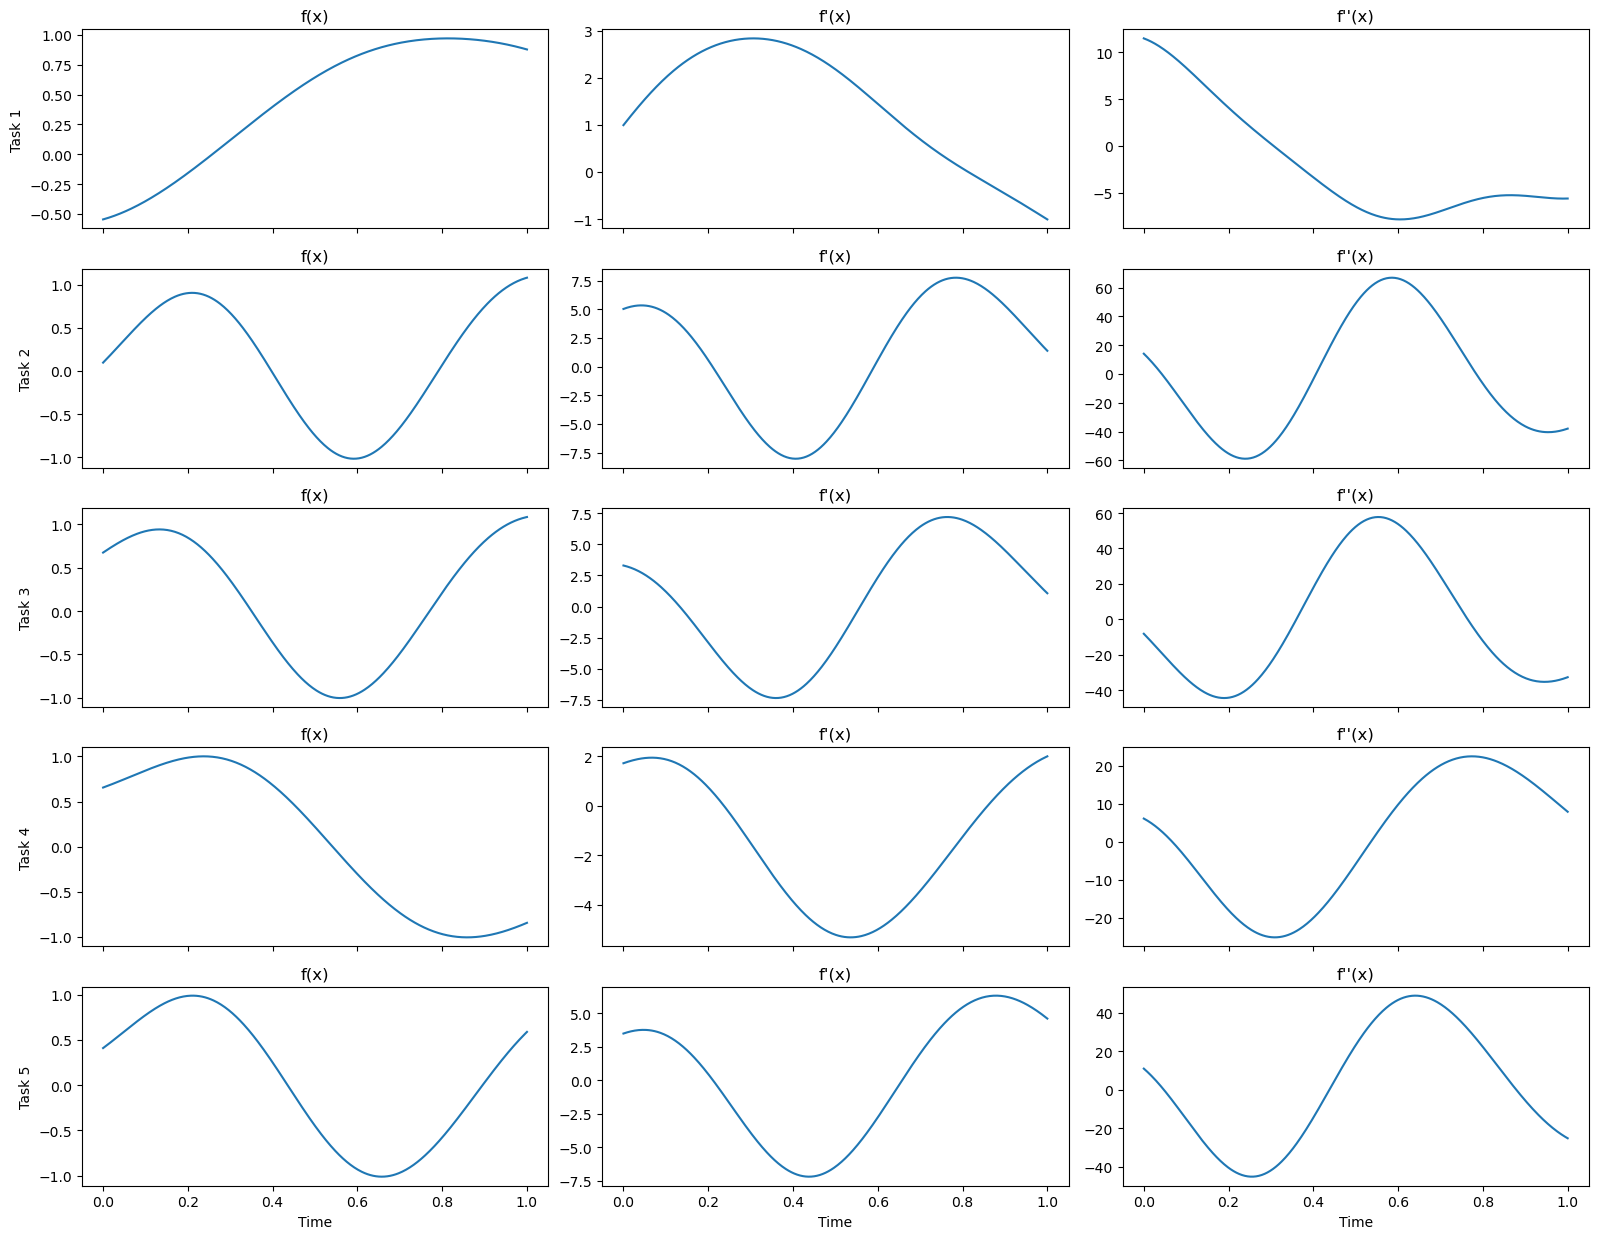

In [ ]:
# Step 1: Prepare x_test across all tasks
x_test = torch.linspace(0, 1, 450).unsqueeze(-1)         # [450, 1]
x_test = x_test.unsqueeze(0).repeat(num_tasks, 1, 1)     # [num_tasks, 450, 1]
x_test.requires_grad_(True)

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var():
    preds = model(x_test)
    mean = preds.mean  # [num_tasks, 450]

# Step 2: Compute derivatives per task
first_derivs = []
second_derivs = []

for task_id in range(num_tasks):
    # First derivative

    f1 = torch.autograd.grad(
        outputs=mean[task_id].sum(),
        inputs=x_test,
        create_graph=True,
        retain_graph=True  # ✅ keep graph for later gradients
    )[0][task_id].squeeze(-1)

    f2 = torch.autograd.grad(
        outputs=f1.sum(),
        inputs=x_test,
        retain_graph=True  # ✅ keep it alive for the next iteration
    )[0][task_id].squeeze(-1)

    first_derivs.append(f1.detach().cpu().numpy())
    second_derivs.append(f2.detach().cpu().numpy())

# Step 3: Convert all to numpy for plotting
x_plot = x_test[0].detach().squeeze().cpu().numpy()      # Shared time axis
mean_np = mean.detach().cpu().numpy()                    # [num_tasks, 450]

# Step 4: Plot grid (num_tasks rows, 3 columns)
fig, axes = plt.subplots(num_tasks, 3, figsize=(16, 2.5 * num_tasks), sharex=True)

for i in range(num_tasks):
    axes[i, 0].plot(x_plot, mean_np[i])
    axes[i, 0].set_ylabel(f"Task {i+1}")
    axes[i, 0].set_title("f(x)")

    axes[i, 1].plot(x_plot, first_derivs[i])
    axes[i, 1].set_title("f'(x)")

    axes[i, 2].plot(x_plot, second_derivs[i])
    axes[i, 2].set_title("f''(x)")

for ax in axes[-1]:
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()
